In [1]:
# Set seed for reproducibility
SEED = 42
LOCAL = True

# Import necessary libraries
import os, subprocess, shlex

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)


def mac_physical_cores():
    try:
        out = subprocess.check_output(shlex.split("sysctl -n hw.physicalcpu")).decode().strip()
        return int(out)
    except Exception:
        return max(1, (os.cpu_count() or 2) // 2)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

if (LOCAL):
    
    PHYS = mac_physical_cores()

    # Leave one core free for the OS (helps thermals on Airs)
    OMP = max(1, PHYS - 1)

    # --- OpenMP / BLAS knobs (set BEFORE importing torch) ---
    os.environ.setdefault("OMP_NUM_THREADS", str(OMP))            # OpenMP (oneDNN, some kernels)
    os.environ.setdefault("VECLIB_MAXIMUM_THREADS", str(OMP))     # Apple Accelerate / vecLib
    os.environ.setdefault("OPENBLAS_NUM_THREADS", str(OMP))       # If any dep uses OpenBLAS
    os.environ.setdefault("MKL_NUM_THREADS", str(OMP))            # Rare on macOS, harmless if unused
    os.environ.setdefault("MKL_DYNAMIC", "FALSE")                 # Avoid oversubscription if MKL present

    device = torch.device("cpu")  # Intel Mac: CPU only

    torch.manual_seed(SEED)
    torch.set_num_threads(OMP)        # intra-op threads
    torch.set_num_interop_threads(1)  # parallel ops; start low on laptops

    print(f"device={device}, physical_cores={PHYS}, "
        f"OMP_NUM_THREADS={OMP}, "
        f"torch_threads={torch.get_num_threads()}, "
        f"interop={torch.get_num_interop_threads()}")





print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

device=cpu, physical_cores=4, OMP_NUM_THREADS=3, torch_threads=3, interop=1
PyTorch version: 2.9.0+cu128
Device: cpu


sysctl: cannot stat /proc/sys/hw/physicalcpu: No such file or directory


In [3]:
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

X_test = pd.read_csv('pirate_pain_test.csv')

In [4]:
print("\n--- Data successfully loaded ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

print("\n--- Initial Feature Count Breakdown ---")
all_features = X_train.columns.drop(['sample_index', 'time'])
joint_features = [col for col in all_features if col.startswith('joint_')]
static_features = [col for col in all_features if col in ['n_legs', 'n_hands', 'n_eyes']]

print(f"Total Features (excluding IDs): {len(all_features)}")
print(f"Core Time-Series (Joints): {len(joint_features)} columns")
print(f"Static Subject Characteristics: {len(static_features)} columns")
print(f"Pain Survey Features: {len(all_features) - len(joint_features) - len(static_features)} columns")




--- Data successfully loaded ---
X_train shape: (105760, 40)
y_train shape: (661, 2)
X_test shape: (211840, 40)

--- Initial Feature Count Breakdown ---
Total Features (excluding IDs): 38
Core Time-Series (Joints): 31 columns
Static Subject Characteristics: 3 columns
Pain Survey Features: 4 columns


In [5]:
print("\n--- Data structure ---")
print("\nX_train Info:")
X_train.info(verbose=True)
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print("\ny_train Info:")
y_train.info(verbose=True)
print(f"\nMissing values in y_train: {y_train.isnull().sum().sum()}")


--- Data structure ---

X_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  flo

In [6]:
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202051,0.197608,0.295605,0.300787,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


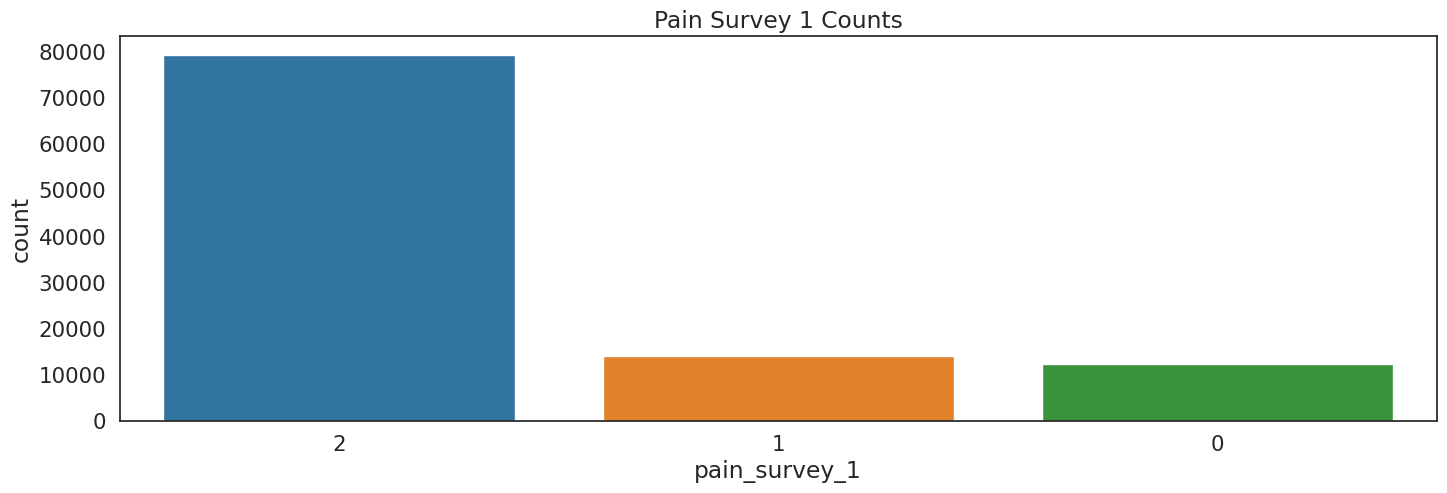

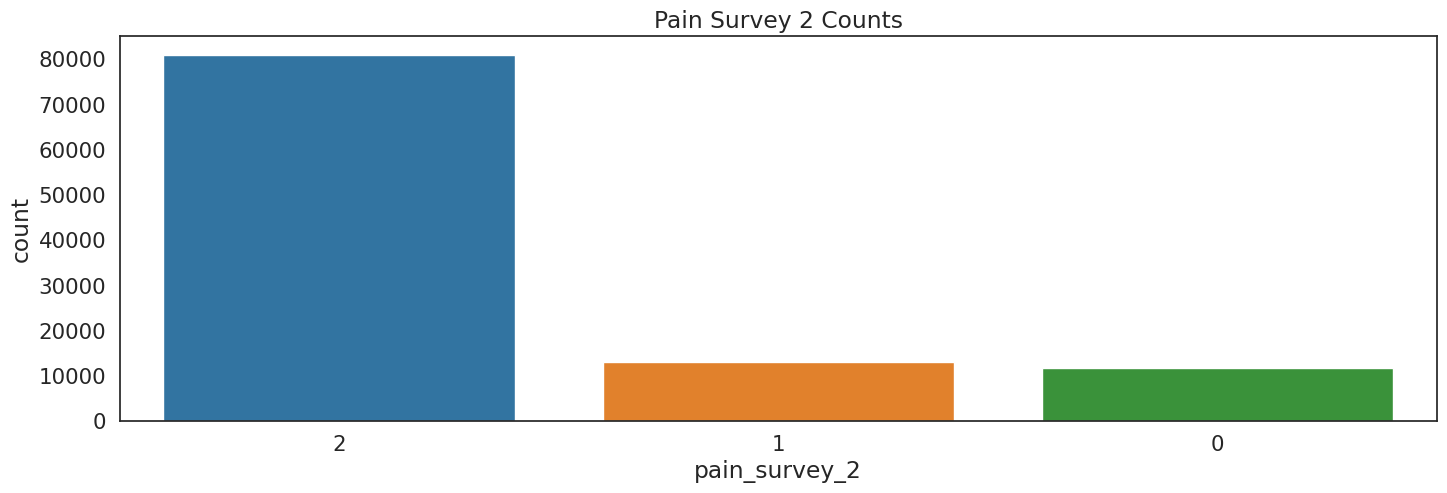

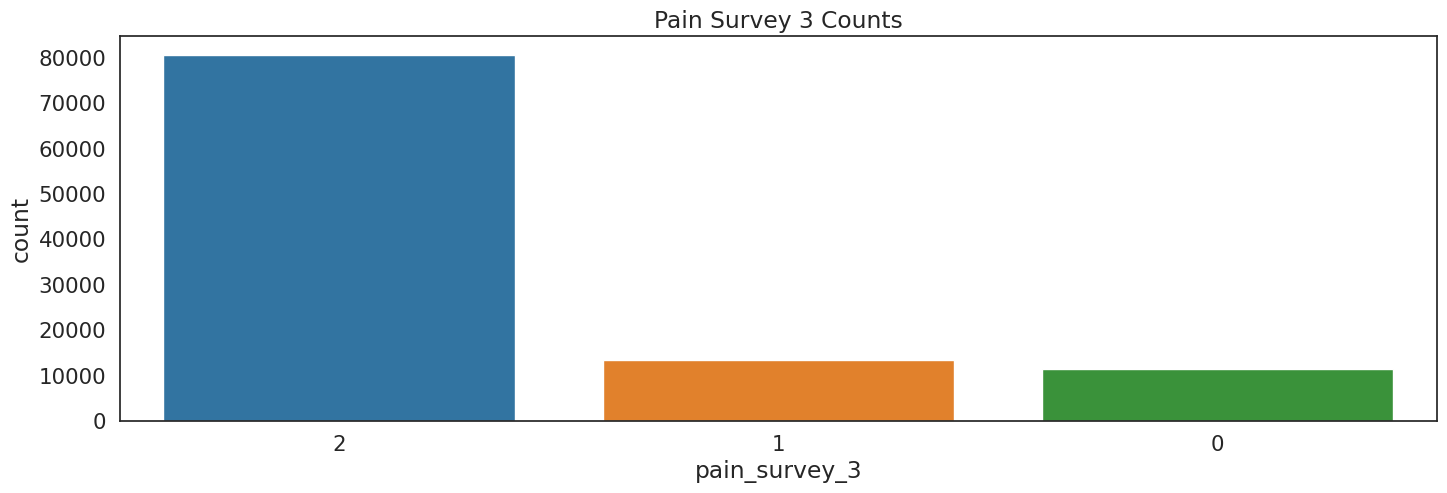

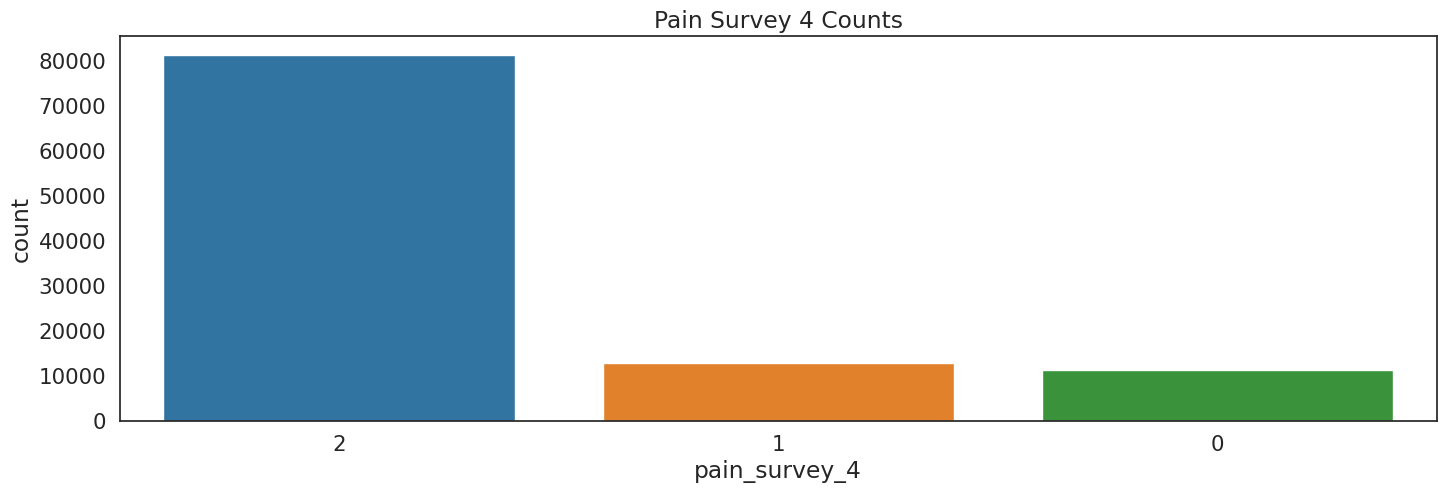

In [7]:
# Visualise the count of timestamps for each activity
plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_1',
    data=X_train,
    order=X_train['pain_survey_1'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 1 Counts')

# Display the plot
plt.show()

plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_2',
    data=X_train,
    order=X_train['pain_survey_2'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 2 Counts')

# Display the plot
plt.show()

plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_3',
    data=X_train,
    order=X_train['pain_survey_3'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 3 Counts')

# Display the plot
plt.show()


plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_4',
    data=X_train,
    order=X_train['pain_survey_4'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 4 Counts')

# Display the plot
plt.show()

In [ ]:
X_train['id'] = X_train['sample_index'].astype('str') + '_' + X_train['time'].astype('str')

print(f'The dataset is composed of {X_train["id"].nunique()} different activity executions')

# Count the unique IDs for distinct activity executions
n_users = len(X_train['id'].unique())

# Create a custom colour map for better distinction of unique IDs
colors = plt.cm.turbo(np.linspace(0, 1, n_users))

# Visualise the count of timestamps per unique ID
plt.figure(figsize=(17, 5))
sns.countplot(
    x='id',
    data=X_train,
    order=X_train['id'].value_counts().index,
    palette=colors
)

# Set the title of the plot and disable x-axis labels for clarity
plt.title('Per Id Timestamps')
plt.xticks([], [])  # Remove x-axis ticks and labels

# Display the plot
plt.show()

The dataset is composed of 105760 different activity executions


In [ ]:
df = X_train

In [ ]:
# Get unique user IDs and shuffle them
unique_users = X_train['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

# Define the number of users for validation and test sets
N_VAL_USERS = 5 # You can change this number
N_TEST_USERS = 5 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_users[:n_train_users]
val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
test_users = unique_users[n_train_users + N_VAL_USERS:]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]
df_test = df[df['sample_index'].isin(test_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')
print(f'Test set shape: {df_test.shape}')